In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pylab as plt
import random
from scipy import stats
from sklearn.neighbors import KDTree
import time
from sklearn.metrics import mean_squared_error
from astropy.cosmology import FlatLambdaCDM
from os import listdir
import desispec
import desispec.io
import speclite.filters
import scipy
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from desitarget.cmx.cmx_targetmask import cmx_mask
from scipy.interpolate import NearestNDInterpolator


In [2]:
## reading everest target selection

n=30*10**3
nw=7781
run=2

spectra=np.load("/global/homes/a/ashodkh/results/spectra_"+str(run)+".txt.npz")["arr_0"]
redshifted_waves=np.load("/global/homes/a/ashodkh/results/redshifted_waves_"+str(run)+".txt.npz")["arr_0"]
zs=np.load("/global/homes/a/ashodkh/results/zs_"+str(run)+".txt.npz")["arr_0"]
target_ids=np.load("/global/homes/a/ashodkh/results/target_ids_bin_"+str(run)+".txt.npz")["arr_0"]
target_lines=np.load("/global/homes/a/ashodkh/results/target_lines_"+str(run)+".txt.npz")["arr_0"]

588
588
588
588
588
588
588
588
588


(6400.0, 6600.0)

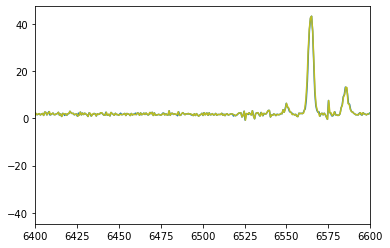

In [3]:
# plotting to check spectra and interpolation quality
w1=3400
w2=7000
plt.figure(1)
plt.plot(redshifted_waves[0,:],spectra[0,:])
plt.axvline(x=w1,color='r')
plt.axvline(x=w2,color='r')

## getting average separation to use for interpolation
d=np.average(redshifted_waves[:,1]-redshifted_waves[:,0])
#d=0.1

## setting up wavelength bins to calculate fluxes in them
big_bin=np.arange(w1,w2,d)
N=10
bin_ws=np.linspace(w1,w2,N)
small_bins=[]
for i in range(N-1):
    small_bins.append(np.arange(bin_ws[i],bin_ws[i+1],d))

## checking nearest neighbor interpolation quality
for i in range(N-1):
    bin1=np.arange(bin_ws[i],bin_ws[i+1],d)
    x=redshifted_waves[0,:]
    tree=KDTree(x.reshape(-1,1))
    dist, ind=tree.query(bin1.reshape(-1,1),k=1)
    spectrum_test=spectra[0,ind]
    #spectrum_test=np.interp(bin1,redshifted_waves[0,:],spectra[0,:])
    print(len(bin1))
    plt.figure(1)
    plt.plot(bin1,spectrum_test)


plt.figure(1)
plt.xlim(6400,6600)

In [4]:
## calculating fluxes in bins for all the spectra
c=3*10**18

fluxes_bin=np.zeros([n,N-1])
for i in range(n):
    for j in range(N-1):
        x=redshifted_waves[i,:]
        tree=KDTree(x.reshape(-1,1))
        dist, ind=tree.query(small_bins[j].reshape(-1,1),k=1)
        spectra_bin=spectra[i,ind].reshape(-1) 
        nans=np.where(np.isnan(spectra_bin[:]))[0]
        av=np.average(spectra_bin[spectra_bin==spectra_bin])
        spectra_bin[np.where(np.isnan(spectra_bin))[0]]=av
        #spectra_bin=np.interp(small_bins[j],redshifted_waves_s[i,:],spectra_s[i,:])
        fluxes_bin[i,j]=(10**23/3631)*np.trapz(10**(-17)*spectra_bin*small_bins[j]*(1+zs[i]),small_bins[j])\
                        /np.trapz(c/small_bins[j],small_bins[j])



In [5]:
np.savez_compressed("/global/homes/a/ashodkh/results/fluxes_bin_"+str(run)+".txt",fluxes_bin)
np.savez_compressed("/global/homes/a/ashodkh/results/zs_s_"+str(run)+".txt",zs)
np.savez_compressed("/global/homes/a/ashodkh/results/target_lines_s_"+str(run)+".txt",target_lines)
np.savez_compressed("/global/homes/a/ashodkh/results/target_ids_s_"+str(run)+".txt",target_ids)